## Analysis

In [46]:
import glob
import pickle
import yaml
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial

from typing import Callable

### Helper functions

In [47]:
def load_all_results(file_pattern=f'results-b*.pkl'):
    res = []

    result_files = glob.glob(file_pattern)
    print(f'Concatenating results from {len(result_files)} results file(s).')

    # Load each file and concatenate the results
    for file in result_files:
        with open(file, 'rb') as f:
            results = pickle.load(f)
            res.extend(results)

    return res

In [48]:
def single_perturbation_results_table(results, score_fn, labels=None, matrix_key='res'):

    cols = ['gene', 'expr']
    df = pd.DataFrame(results, columns=cols)

    # Extract the genes and expression values stored in arrays
    for col in cols:
        df[col] = df[col].apply(lambda x: x[0])

    # Apply the score function
    scores = [score_fn(exp[matrix_key].copy()) for exp in results]
    df_scores = pd.DataFrame(scores)
    if labels is not None:
        df_scores.columns = labels

    return df.join(df_scores)

In [49]:
# Custom scoring metrics
def calc_state_probs(mtx, *, threshold=None, one_way=False, normalize=True, markov_iter=3):

    if threshold is not None:
        mtx[mtx < threshold] = 0

    if one_way:
        mtx[mtx - mtx.T < 0] = 0

    if normalize:
        mtx /= mtx.sum(1)[:, None]

    # Initialize a state probability matrix (b x N) with equal initial probability for each cell type in each experiment
    n, _ = mtx.shape
    probabilities = np.ones(n)/n

    # Update the probabilities for each experiment
    for _ in range(markov_iter):
        probabilities = np.matmul(probabilities, mtx)

    return probabilities

def get_diag(mtx):
  return np.diag(mtx)

def get_idx(mtx, *, idx):
  return mtx[tuple(zip(*idx))]

In [50]:
def plot_by_perturbation(results_table, y, *, genes: list | None = None) -> plt.Figure:

    res = results_table.copy()

    # Filter the data for the specified genes (or assume we are plotting all genes)
    if genes is not None:
        res = res[res['gene'].isin(genes)]
    else:
        genes = res['gene'].unique()

    # Create a figure with subplots for each gene
    num_genes = len(genes)
    fig, axes = plt.subplots(nrows=num_genes, ncols=1, figsize=(8, num_genes * 4), sharex=True)

    if num_genes == 1:
        axes = [axes]

    # Plot each gene's data
    for ax, gene in zip(axes, genes):
        gene_data = res[res['gene'] == gene]
        ax.scatter(gene_data['expr'], gene_data[y], label=gene)
        ax.set_title(f'{str(y)} vs pertubration for {gene}')
        ax.set_ylabel(f'{str(y)}')
        ax.legend()

    axes[-1].set_xlabel('Perturbation level')

    plt.show()

    return fig


In [51]:
def bin_values(x, *, bin_centers=None, n_bins=None, floor=True):
    x = np.array(x)
    bin_x = np.zeros_like(x)

    if bin_centers is not None:
        # Use bin centers to calculate bin edges
        bin_centers = np.sort(np.array(bin_centers))
        bin_edges = (bin_centers[:-1] + bin_centers[1:]) / 2
        bin_edges = np.concatenate(([-np.inf], bin_edges, [np.inf]))

        bin_indices = np.digitize(x, bin_edges)
        bin_indices = np.clip(bin_indices, 1, len(bin_centers))  # Ensure indices are within valid range
        bin_x = bin_centers[bin_indices - 1]

    elif n_bins is not None:
        # Use n_bins to calculate bin edges based on the range of the data
        bin_edges = np.linspace(np.min(x), np.max(x), n_bins + 1, dtype=(int if floor else None))
        bin_indices = np.digitize(x, bin_edges, right=False)

        # Assign values based on bin indices (centers of the bins)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_indices = np.clip(bin_indices, 1, len(bin_centers))  # Ensure indices are within valid range
        bin_x = bin_centers[bin_indices - 1]

    else:
        raise ValueError("Either bin_centers or n_bins must be specified.")

    return bin_x


In [52]:
def plot_heatmap(results_table: pd.DataFrame, y: str, x: str, values: str, *, sort_values: bool = True, **kwargs) -> plt.Figure:

    # Create pivot table of scores by genes vs expression values
    df = results_table.pivot_table(index=y, columns=x, values=values, aggfunc='mean')

    if sort_values:

        # Calculate the mean of the first half of the columns for each row
        half_point = df.shape[1] // 2
        df['sum_first_half'] = df.iloc[:, :half_point].mean(axis=1)

        # Sort rows by the sum of the first half of the columns
        df.sort_values(by='sum_first_half', axis=0, inplace=True, ascending=False)

        # Drop the helper column used for sorting
        df.drop(columns=['sum_first_half'], inplace=True)

    sns.heatmap(df, **kwargs)
    plt.title(f'{values}')
    fig = plt.gcf()
    plt.show()

    return fig


In [53]:
def calculate_median_scores(data: pd.DataFrame, x: str, y: str, group_by: str, *, ci_alpha = 0.05) -> pd.DataFrame:

    # Initialize a dictionary to hold the results
    results = {}

    # Iterate over each unique gene in the DataFrame
    for g in data[group_by].unique():
        d_g = data[data[group_by]==g]

        # Ensure that each gene has at least one positive and one negative expression value from which to calcuclate the medians
        if (d_g[x] < 0).sum() == 0 or (d_g[x] > 0).sum() == 0:
            print(f'Insufficient data for gene {g} to calculate median score.')
            continue

        results[g] = {}

        # Filter rows where expr_vals is less than 0 and compute the median of the score column
        neg_x, pos_x = d_g[d_g[x] < 0], d_g[d_g[x] > 0]
        results[g][f'{y}_median_neg'] = neg_x[y].median()
        results[g][f'{y}_median_pos'] = pos_x[y].median()

        # Delta
        results[g][f'{y}_median_delta'] =  pos_x[y].median() - neg_x[y].median()

        # Confidence intervals
        if ci_alpha is not None:

            bootstrap_neg_medians = bootstrap_samples(neg_x[y], statistic=np.median)
            bootstrap_pos_medians = bootstrap_samples(pos_x[y], statistic=np.median)

            ci_lower, ci_upper = calculate_ci(bootstrap_pos_medians, alpha=ci_alpha)
            results[g][f'{y}_median_neg_ci_lower'] = ci_lower
            results[g][f'{y}_median_neg_ci_upper'] = ci_upper

            ci_lower, ci_upper = calculate_ci(bootstrap_pos_medians, alpha=ci_alpha)
            results[g][f'{y}_median_pos_ci_lower'] = ci_lower
            results[g][f'{y}_median_pos_ci_upper'] = ci_upper

            bootstrap_delta_medians = bootstrap_pos_medians - bootstrap_neg_medians
            ci_lower, ci_upper = calculate_ci(bootstrap_delta_medians, alpha=ci_alpha)
            results[g][f'{y}_median_delta_ci_lower'] = ci_lower
            results[g][f'{y}_median_delta_ci_upper'] = ci_upper

    return pd.DataFrame(results).T


In [54]:
from scipy.stats import pearsonr, spearmanr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import t

CI_ALPHA = 0.05

# Base class for summary statistics
class SummaryStat:

    def __init__(self, xs, ys, label=None):
        self.xs = xs
        self.ys = ys
        self.label = label


    def calculate_ci(self, ci_alpha=CI_ALPHA, bootstrap_samples=1000) -> dict:
        bootstrap_statistics = []
        for _ in range(bootstrap_samples):
            indices = np.random.choice(range(len(self.xs)), size=len(self.xs), replace=True)
            bootstrap_xs = self.xs[indices]
            bootstrap_ys = self.ys[indices]
            stat_instance = self.__class__(bootstrap_xs, bootstrap_ys, label=self.label)
            bootstrap_statistics.append(stat_instance.calculate())

        bootstrap_df = pd.DataFrame(bootstrap_statistics)
        ci_lower = bootstrap_df.quantile(ci_alpha / 2)
        ci_upper = bootstrap_df.quantile(1 - ci_alpha / 2)

        ci = {}
        for col in ci_lower.index:
            ci[f'{col}_ci_lower'] = ci_lower[col]
            ci[f'{col}_ci_upper'] = ci_upper[col]
        return ci

    def calculate(self):
        raise NotImplementedError("Subclasses should implement this method")

# Dictionary to hold the summary statistics classes
summary_stats = {}

# Decorator to register classes in the summary_stats dictionary
def summary_stat(key=None):
    def decorator(cls):
        summary_stats[key if key is not None else cls.__name__] = cls
        return cls
    return decorator

@summary_stat(key='median_delta')
class MedianDifferenceStat(SummaryStat):
    def calculate(self):
        median_pos = np.median(self.ys[self.xs > 0])
        median_neg = np.median(self.ys[self.xs < 0])
        median_delta = median_pos - median_neg
        return {
            f'{self.label}_median_pos': median_pos,
            f'{self.label}_median_neg': median_neg,
            f'{self.label}_median_delta': median_delta
        }

@summary_stat(key='correlation')
class CorrelationStat(SummaryStat):
    def calculate(self):
        pearson_coef = pearsonr(self.xs, self.ys)[0]
        spearman_coef = spearmanr(self.xs, self.ys)[0]
        return {
            f'{self.label}_pearson': pearson_coef,
            f'{self.label}_spearman': spearman_coef
        }

@summary_stat(key='lr')
class LinearRegressionStat(SummaryStat):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])

    def calculate(self):
        self.pipeline.fit(self.xs.reshape(-1, 1), self.ys)
        lr = self.pipeline.named_steps['regressor']
        return {f'{self.label}_lr_b{i}': coeff for i, coeff in enumerate([lr.intercept_, *lr.coef_])}

    def calculate_ci(self, ci_alpha=CI_ALPHA) -> dict:

        # Calculate prediction intervals for the coefficients
        X_scaled = self.pipeline.named_steps['scaler'].transform(self.xs.reshape(-1, 1))
        y_pred = self.pipeline.named_steps['regressor'].predict(X_scaled)
        residuals = self.ys - y_pred
        RSS = np.sum(residuals**2)
        n, p = X_scaled.shape

        # Variance of the residuals
        X_with_intercept = np.hstack((np.ones((n, 1)), X_scaled))
        s_squared = RSS / (n - p - 1)

        # Calculate the standard error of the regression
        var_y_pred = s_squared * np.linalg.inv(X_with_intercept.T @ X_with_intercept)
        se_y_pred = np.sqrt(np.diag(var_y_pred))

        # Calculate t critical value for the prediction interval
        t_critical = t.ppf(1 - ci_alpha / 2, df=n - p - 1)

        # Calculate prediction intervals
        ci = {}
        lr = self.pipeline.named_steps['regressor']
        coeffs = [lr.intercept_] + list(lr.coef_)
        for i, (coeff, se) in enumerate(zip(coeffs, se_y_pred)):
            ci[f'{self.label}_lr_b{i}_ci_lower'] = coeff - t_critical * se
            ci[f'{self.label}_lr_b{i}_ci_upper'] = coeff + t_critical * se

        return ci

    def predict(self, new_xs):
        # Use the pipeline to predict ys
        return self.pipeline.predict(new_xs.reshape(-1, 1))

# Function to calculate scores with confidence intervals
def calc_summary_stat(data: pd.DataFrame, x: str, y: str, group_by: str, stat_cls: str | SummaryStat, return_estimators=False, ci_alpha=CI_ALPHA, **kwargs) -> pd.DataFrame:
    results = {}
    estimators = {}

    if isinstance(stat_cls, str):
        stat_cls = summary_stats[stat_cls]

    for g in data[group_by].unique():
        d_g = data[data[group_by] == g]
        xs = d_g[x].values
        ys = d_g[y].values

        stat_instance = stat_cls(xs, ys, label=y)

        # Calculate the summary statistics
        stats = stat_instance.calculate()

        # Calculate confidence intervals
        if ci_alpha is not None:
            ci = stat_instance.calculate_ci(**kwargs)
            stats.update(ci)

        results[g] = stats
        estimators[g] = stat_instance

    if return_estimators:
        return pd.DataFrame(results).T, estimators

    return pd.DataFrame(results).T


In [55]:
import statsmodels.api as sm
from scipy.stats import norm

def calculate_lr_scores(data, x: str, y: str, group_by: str, *, ci_alpha = 0.05, return_models=True, verbose=False):

    results = {}
    linear_models = {}

    for g in data[group_by].unique():
        d_g = data[data[group_by] == g]
        x_vals = (d_g[x] - d_g[x].mean()) / d_g[x].std()  # normalize
        y_vals = d_g[y]

        X = sm.add_constant(np.array(x_vals).reshape(-1, 1))
        model = sm.OLS(y_vals, X)
        model_results = model.fit()

        if verbose:
            print(model_results.summary())

        ci_z = norm.ppf(1 - ci_alpha / 2)

        linear_models[g] = model_results
        b0, b1 = model_results.params
        results[g] = {
            y + '_lr_b0': b0,
            y + '_lr_b1': b1,
        }
        if ci_alpha is not None:
            results[g].update({
                y + '_lr_b1_ci_lower': b1 - model_results.bse[1] * ci_z,
                y + '_lr_b1_ci_upper': b1 + model_results.bse[1] * ci_z,
            })

    df_res = pd.DataFrame(results).T

    if return_models:
        return df_res, linear_models

    return df_res

In [56]:
def bootstrap_ci(data: np.ndarray, statistic: Callable[[np.ndarray],float], n_bootstrap: int = 1000, alpha: float = 0.05):
  stats = bootstrap_samples(data, n_bootstrap=n_bootstrap, statistic=statistic)
  return calculate_ci(stats, alpha=alpha)

def bootstrap_samples(data: np.ndarray, n_bootstrap: int = 1000, statistic: Callable[[np.ndarray],float] | None = None):
  samples = np.random.choice(data, size=(n_bootstrap, len(data)), replace=True)
  if statistic is not None:
    return np.apply_along_axis(statistic, axis=1, arr=samples)

  return samples

def calculate_ci(stats: np.ndarray, alpha: float = 0.05):
  ci_lower = np.percentile(stats, alpha/2 * 100)
  ci_upper = np.percentile(stats, (1-alpha/2) * 100)
  return ci_lower, ci_upper


In [57]:
def barplot_with_errorbars(df: pd.DataFrame, labels: list, *, sort_ascending: bool | None = None, label_lower: str = '_ci_lower', label_upper: str = '_ci_upper') -> plt.Figure:

    df = df.copy()

    if sort_ascending is not None:
        df.sort_values(by=labels[0], ascending=sort_ascending, inplace=True)

    n_labels = len(labels)
    bar_width = 1 / (n_labels + 1)  # Adjust bar width based on the number of labels
    x = np.arange(len(df))  # The label locations
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, label in enumerate(labels):

        # Calculate the error margins relative to the medians
        df['error_lower'] = df[label] - df[f'{label}{label_lower}']
        df['error_upper'] = df[f'{label}{label_upper}'] - df[label]

        # Set up error bars in the format expected by matplotlib (positive, negative)
        error_bars = [df['error_lower'].values, df['error_upper'].values]

        # Plotting
        ax.bar(x + i * bar_width, df[label], bar_width, yerr=error_bars, capsize=4, label=label)

    ax.set_ylabel('Values')
    ax.set_xticks(x + bar_width * (n_labels - 1) / 2)
    ax.set_xticklabels(df.index)
    plt.xticks(rotation=0)  # Rotates the labels on the x-axis for better readability
    plt.legend()

    return fig

## Load

In [68]:
from utils.config import load_config

config = load_config('../config.yaml')
config.resolve_paths()

In [69]:
# Globals

cwd = os.path.abspath(f'../{config.working_directory}')
expr_vals = np.linspace(*config.perturbation_range, num=config.perturbation_steps).astype(int)

In [70]:
# Load in results
# res = load_all_results()
with open(os.path.join(cwd, config.compiled_results_file), 'rb') as file:
    results = pickle.load(file)

In [71]:
# Drop missing data
def drop_missing(res, result_key='res'):
    out = [r for r in res if r[result_key] is not None]
    print(f'Dropped {len(res) - len(out)} missing results.')
    return out

res = drop_missing(results['results'])

Dropped 0 missing results.


In [72]:
genes_list = results.get('included_genes', [])
group_labels = results.get('group_labels', [])

### Calculate score of interest

Choose from or modify one of the following scoring methods below:



In [73]:
scoring_methods = {}

# Use the cell state probabilities as the score (Markov chain calculation)
scoring_methods['markov_state_probs'] = {
    'score_fn': partial(calc_state_probs, markov_iter=3),
    'labels': [f'{group}_state_prob' for group in group_labels]
}

# Use the self-transition probabilities as the score
scoring_methods['diag_mtx'] = {
    'score_fn': np.diag,
    'labels': [f'{group}_diag' for group in group_labels]
}

# Use custom matrix value(s) as the score
mtx_idx = [[0, 1]]  # Back to Velvet
score_labels = {(i, j): f"{group_labels[i]}-{group_labels[j]}_trans_prob" for i in range(len(group_labels)) for j in range(len(group_labels))}
scoring_methods['mtx_idx'] = {
    'score_fn': partial(get_idx, idx=mtx_idx),
    'labels': [score_labels[tuple(i)] for i in mtx_idx]
}

# Define a custom function of matrix values as the score
def score_fn_dynamism(mtx):
    mtx /= mtx.sum(1)[:, None]  # normalize values
    return np.sum(np.abs(mtx - np.eye(mtx.shape[0])))

scoring_methods['dynamism'] = {
    'score_fn': score_fn_dynamism,
    'labels': ['dynamism']
}

# Here's a simpler custom function of matrix values
def score_fn_mtx_algebra(mtx):
    return mtx[0, 0] - mtx[1, 1]

scoring_methods['mtx_algebra'] = {
    'score_fn': score_fn_mtx_algebra,
    'labels': ['delta']
}

# scoring_methods.keys()

In [74]:
# Set scoring method from list above
scoring_method = "markov_state_probs" # @param ['markov_state_probs', 'diag_mtx', 'mtx_idx', 'dynamism', 'mtx_algebra'] {allow-input: true}
df_res = single_perturbation_results_table(res, **scoring_methods[scoring_method])

# Show a sample of the calculated scores
df_res.head()

,gene,expr,D3_Back_state_prob,D7_Velvet_state_prob,D7_Back_state_prob,D0_Velvet_state_prob,D14_Velvet_state_prob,D3_Velvet_state_prob,D14_Back_state_prob,D0_Back_state_prob
0,PLAU,-1000,0.130899,0.306918,0.078772,0.076143,0.152277,0.091759,0.055097,0.108134
1,PLAU,-777,0.090754,0.265108,0.112069,0.090470,0.194374,0.084439,0.040761,0.122024
2,PLAU,-555,0.132093,0.267842,0.101249,0.081239,0.166856,0.100222,0.048829,0.101669
3,PLAU,-333,0.109397,0.263014,0.107467,0.061517,0.204525,0.120271,0.037158,0.096650
4,PLAU,-111,0.139299,0.334191,0.129486,0.041150,0.138051,0.112709,0.042865,0.062249


### Visualize scores

In [75]:
# Specify the dependent variable of interest
y = 'D14_Velvet_state_prob'
# y = scoring_methods[scoring_method]['labels'][-1] # comment this out

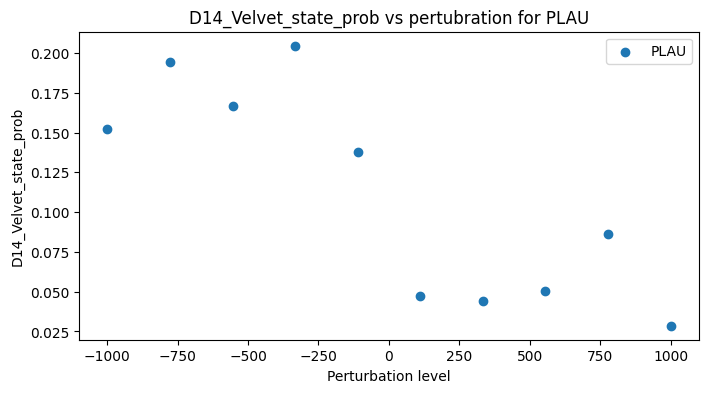

In [76]:
# We can plot the score against expr_val for a given list of genes
# plot_by_perturbation(df_res, y=y, genes=np.unique(genes_list)[:1])

# Or we can plot all genes if there are only a few
# plot_by_perturbation(df_res, y=y)

# Or we can loop through the genes, plot them one-by-one, and save the results
os.makedirs(os.path.join(cwd, 'analysis/plots'), exist_ok=True)
for gene in genes_list:
    fig = plot_by_perturbation(df_res, y=y, genes=[gene])
    file_name = f'{gene}_{str(y)}.png'
    fig.savefig(os.path.join(cwd, 'analysis/plots', file_name))

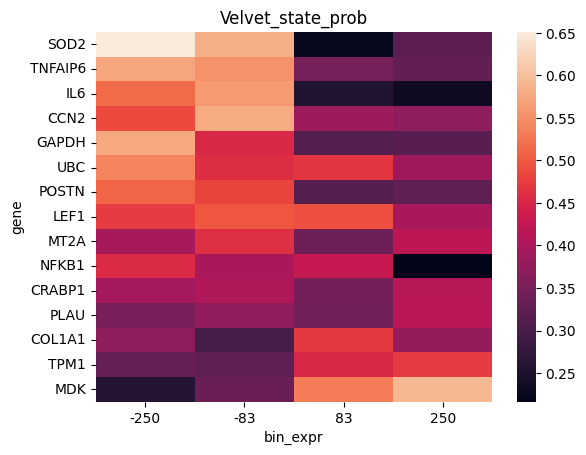

In [37]:
# We can also use a heatmap to visualize the score for each perturbation level for each gene
# Bin the expr_vals to account for slight deviations during dynamo perturbation re-attempts
df_res['bin_expr'] = bin_values(df_res['expr'], bin_centers=expr_vals.reshape(-1))
fig = plot_heatmap(df_res, y='gene', x='bin_expr', values=y, sort_values=True)

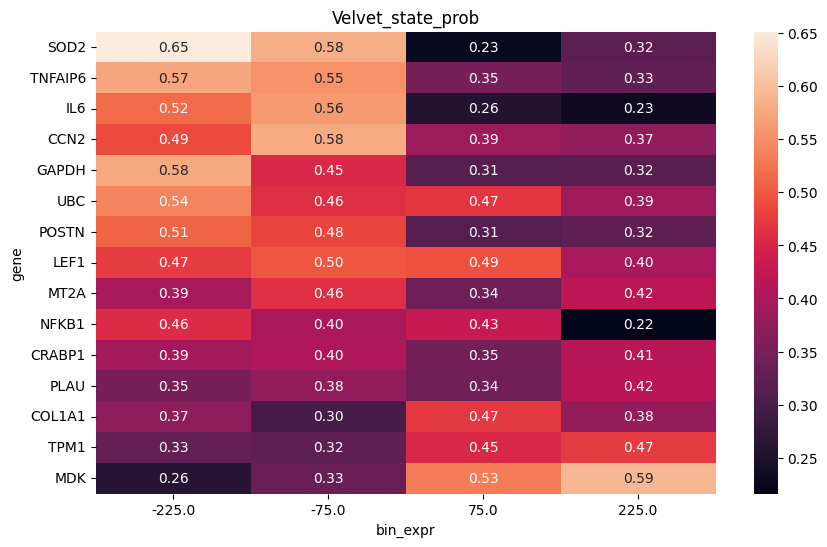

In [38]:
# If desired, the appearance (bins, size, etc.) of the heatmap can be altered
df_res['bin_expr'] = bin_values(df_res['expr'], n_bins=10)
plt.figure(figsize=(10, 6))
fig = plot_heatmap(df_res, y='gene', x='bin_expr', values=y, sort_values=True, annot=True, fmt='.2f')

# Save the plot
file_name = f'heatmap_{str(y)}.png'
fig.savefig(os.path.join(cwd, 'analysis/plots', file_name))

### Summary statistics

In [90]:
# List the summary stats available
summary_stats

{'median_delta': __main__.MedianDifferenceStat,
 'correlation': __main__.CorrelationStat,
 'lr': __main__.LinearRegressionStat}



*   **Median Delta** calculates the median score over the positive pertubrations and the negative perturbations and takes their difference.

*   **Linear Regression** fits the score data to a linear model $ y = \beta_0 + \beta_1 x $. The $\beta_1$ coefficient can then be used a measure of the relationship between score and perturbation level. Note that the model will run a pipeline that provides standard scaling for perturbation level.

*   **Correlation** provides the Pearson and Spearman correlation coefficients. Both measure the strength and direction of association between the score and perturbation value. Whereas the Pearson correlation coefficient assesses the linear relationship between the two variables, assuming normal distribution, the Spearman correlation coefficient evaluates any monotonic relationship, capturing both linear and non-linear associations without assuming normality and being less affected by outliers.




In [39]:
# Calculate the median delta statistic
median_delta_stat = calc_summary_stat(df_res, x='expr', y=y, group_by='gene', stat_cls='median_delta')
median_delta_stat.head()

/Users/matthewmazurek/Library/Caches/pypoetry/virtualenvs/perturbation-screen-dje1g3KK-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/matthewmazurek/Library/Caches/pypoetry/virtualenvs/perturbation-screen-dje1g3KK-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/matthewmazurek/Library/Caches/pypoetry/virtualenvs/perturbation-screen-dje1g3KK-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/matthewmazurek/Library/Caches/pypoetry/virtualenvs/perturbation-screen-dje1g3KK-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/matthewmazure

,Velvet_state_prob_median_pos,Velvet_state_prob_median_neg,Velvet_state_prob_median_delta,Velvet_state_prob_median_pos_ci_lower,Velvet_state_prob_median_pos_ci_upper,Velvet_state_prob_median_neg_ci_lower,Velvet_state_prob_median_neg_ci_upper,Velvet_state_prob_median_delta_ci_lower,Velvet_state_prob_median_delta_ci_upper
GAPDH,0.314789,0.514956,-0.200166,0.313151,0.316428,0.453482,0.576429,-0.263278,-0.137055
CCN2,0.379985,0.533031,-0.153046,0.373857,0.386114,0.487082,0.578981,-0.205124,-0.100968
CRABP1,0.378946,0.398761,-0.019815,0.345860,0.412032,0.393027,0.404494,-0.058635,0.019005
MDK,0.562602,0.297680,0.264922,0.533201,0.592003,0.260606,0.334755,0.198446,0.331397
PLAU,0.379049,0.362174,0.016875,0.342387,0.415711,0.349140,0.375208,-0.032821,0.066571


In [40]:
# Calculate correlations with Pearson and Spearman correlation coefficients
# We can specify a ci_alpha level to get the corresponding confidence interval
# Setting ci_alpha = None suppresses this calculation
# We can also manually set the number of bootstrap_samples for quantile CI estimation
corr_stat = calc_summary_stat(df_res, x='expr', y=y, group_by='gene', stat_cls='correlation', ci_alpha=.05, bootstrap_samples=100)
corr_stat.head()

/var/folders/zk/wkbllc610p5ch3kwjgfj6jkc0000gn/T/ipykernel_43509/2978277939.py:65: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_coef = pearsonr(self.xs, self.ys)[0]
/var/folders/zk/wkbllc610p5ch3kwjgfj6jkc0000gn/T/ipykernel_43509/2978277939.py:66: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_coef = spearmanr(self.xs, self.ys)[0]
/var/folders/zk/wkbllc610p5ch3kwjgfj6jkc0000gn/T/ipykernel_43509/2978277939.py:65: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_coef = pearsonr(self.xs, self.ys)[0]
/var/folders/zk/wkbllc610p5ch3kwjgfj6jkc0000gn/T/ipykernel_43509/2978277939.py:66: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_coef = spearmanr(self.xs, self.ys)[0]
/var/folders/zk/wkbllc610p5ch3kwjgfj6jkc0000gn/T/ipykernel_43509/2978277939.py:65: ConstantInputWarn

,Velvet_state_prob_pearson,Velvet_state_prob_spearman,Velvet_state_prob_pearson_ci_lower,Velvet_state_prob_pearson_ci_upper,Velvet_state_prob_spearman_ci_lower,Velvet_state_prob_spearman_ci_upper
GAPDH,-0.942757,-0.8,-1.000000,1.0,-1.0,1.0
CCN2,-0.714462,-0.8,-1.000000,1.0,-1.0,1.0
CRABP1,-0.006025,0.4,-1.000000,1.0,-1.0,1.0
MDK,0.975731,1.0,0.932824,1.0,1.0,1.0
PLAU,0.649144,0.4,-1.000000,1.0,-1.0,1.0


In [41]:
# Calculate the linear regression statistic
# The prediction intervals are calculated using the residual variance and model parameter covariance matrix
# Specifying return_estimators=True allows us to extract the regression models for later use (see below)
lr_stat, lr_models = calc_summary_stat(df_res, x='expr', y=y, group_by='gene', stat_cls='lr', return_estimators=True)
lr_stat.head()

,Velvet_state_prob_lr_b0,Velvet_state_prob_lr_b1,Velvet_state_prob_lr_b0_ci_lower,Velvet_state_prob_lr_b0_ci_upper,Velvet_state_prob_lr_b1_ci_lower,Velvet_state_prob_lr_b1_ci_upper
GAPDH,0.414873,-0.102875,0.304159,0.525586,-0.213589,0.007839
CCN2,0.456508,-0.059477,0.279297,0.633719,-0.236688,0.117734
CRABP1,0.388853,-0.000155,0.310578,0.467128,-0.078430,0.078120
MDK,0.430141,0.133305,0.339123,0.521160,0.042287,0.224324
PLAU,0.370611,0.018681,0.304010,0.437213,-0.047920,0.085283


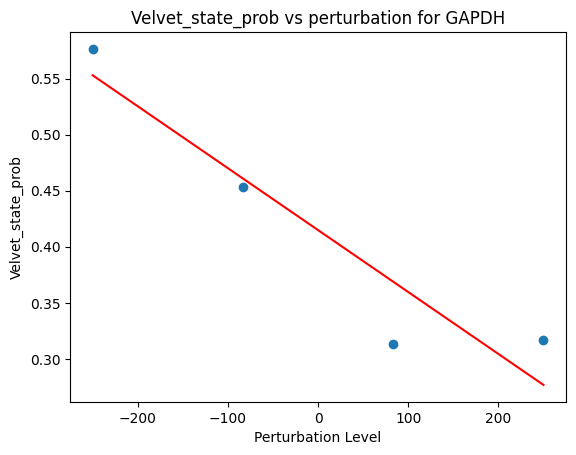

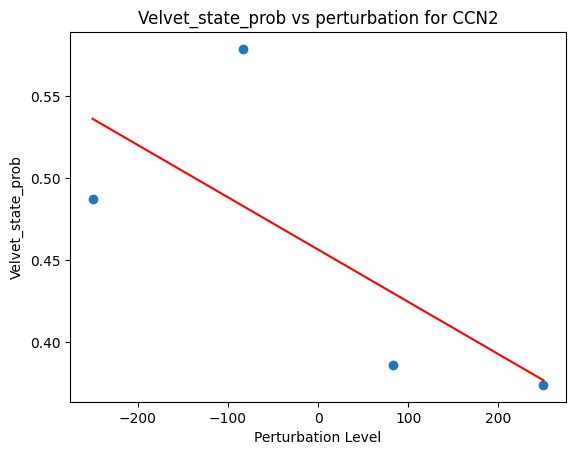

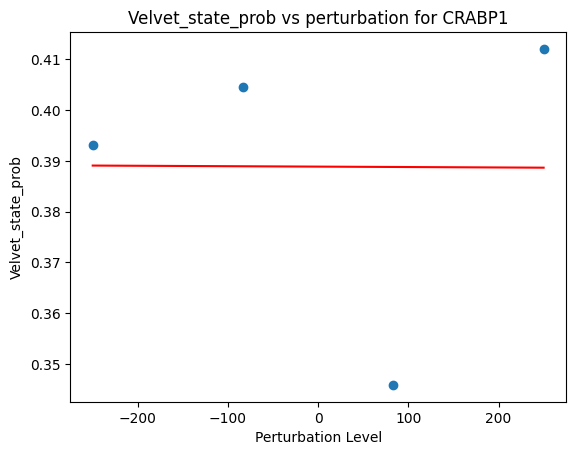

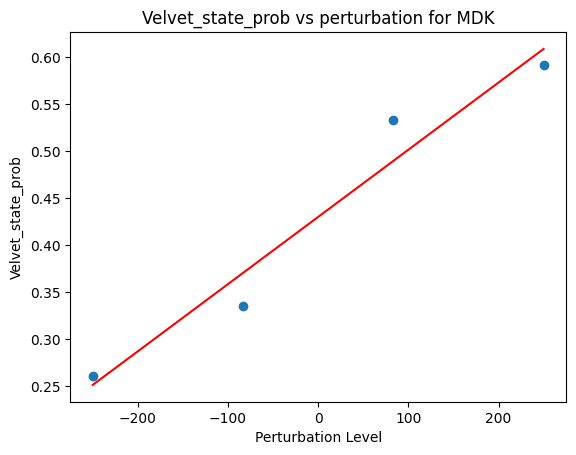

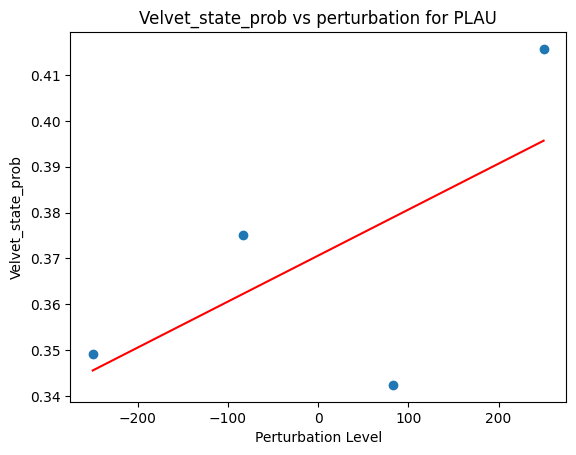

In [42]:
# We can observe how theses models fit the data; here, we loop through the first 5 genes for illustration
def plot_model_fits(genes):
    for gene in genes:
        df = df_res[df_res['gene'] == gene]
        data_x, data_y = df['expr'], df[y]
        m = lr_models[gene]
        xs = np.linspace(min(data_x), max(data_x), 100)
        ys = m.predict(xs)

        plt.scatter(data_x, data_y)
        plt.plot(xs, ys, color='red')
        plt.xlabel('Perturbation Level')
        plt.ylabel(f'{y}')
        plt.title(f'{y} vs perturbation for {gene}')
        plt.show()

plot_model_fits(genes_list[:5])

In [43]:
# Let's concatenate the summary stats and save the table to a csv file
summary_table = pd.concat([median_delta_stat, lr_stat, corr_stat], axis=1)
summary_table.to_csv(os.path.join(cwd, 'analysis', f'{y}_summary_table.csv'))

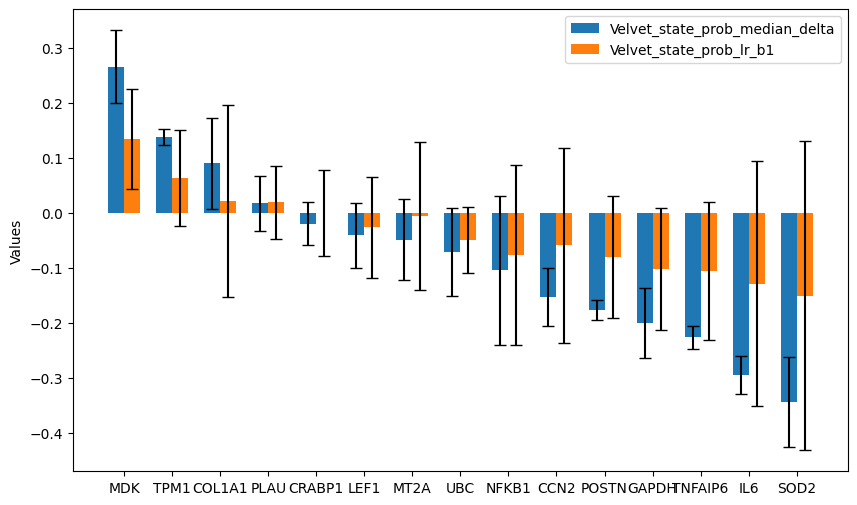

In [44]:
# The barplot_with_errorbars function can plot the summary statistics
# when provided a list of labels from the tables above.
# The plotting function will look for error values in the appropraite '_ci_lower', '_ci_upper' cols
labels = [f'{y}_median_delta', f'{y}_lr_b1']
fig = barplot_with_errorbars(summary_table, labels=labels, sort_ascending=False)
fig.savefig(os.path.join(cwd, 'analysis/plots', f'{y}_summary_stats.png'))

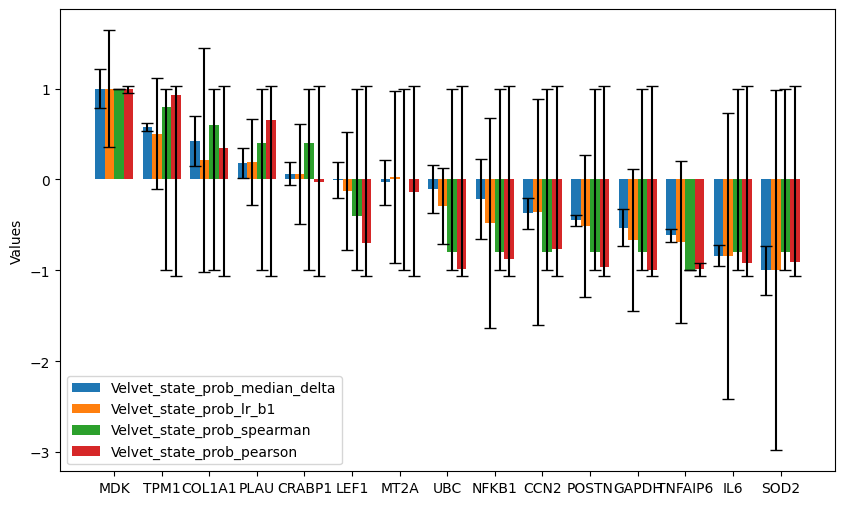

In [45]:
# To compare all the various summary statitics, it's helpful to scale them to lie within (-1, 1)

from sklearn.preprocessing import MinMaxScaler

def scale_summary_table(df, columns):
    df_scaled = df.copy()
    for col in columns:

        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(df[[col]].values)
        df_scaled[col] = scaler.transform(df[[col]].values)

        ci_lower_col = f"{col}_ci_lower"
        ci_upper_col = f"{col}_ci_upper"

        df_scaled[ci_lower_col] = scaler.transform(df[[ci_lower_col]].values)
        df_scaled[ci_upper_col] = scaler.transform(df[[ci_upper_col]].values)

    return df_scaled

labels=[f'{y}_median_delta', f'{y}_lr_b1', f'{y}_spearman', f'{y}_pearson']
summary_table_scaled = scale_summary_table(summary_table, labels)
fig = barplot_with_errorbars(summary_table_scaled, labels=labels, sort_ascending=False)